In [1]:
# module imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Subset
import matplotlib.pyplot as plt
from sklearn import metrics
from dataset import OneHotGenomeDataset
from dataloaders import BatchedGenomeDataLoader
from models import OneConv

In [2]:
# hyper parameters
max_epoch = 100
batch_size = 500
vocab_size = 5 # A, C, G, T, N
embed_dim = 5
out_size = 2

In [3]:
# train data
train_path = "../data/undersampled_train.csv"
train_set = OneHotGenomeDataset(train_path)
train_dataloader = BatchedGenomeDataLoader(train_set, batch_size=batch_size)

In [4]:
# criterion
# weight = torch.tensor([100.0, 1.0]).cuda()
criterion = nn.BCEWithLogitsLoss()

In [5]:
# model & optimizer
model = OneConv(vocab_size, embed_dim, out_size=out_size).cuda()
optimizer = optim.Adam(model.parameters())

In [6]:
# training
model.train()
for epoch in range(max_epoch):
    total_loss, count = 0, 0

    for x, t in train_dataloader:
        optimizer.zero_grad()
        y = model(x)
        loss = criterion(y, t)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data
        count += 1

    avg_loss = total_loss/count

    if epoch%10 == 9:
        print("| epoch %d | loss %f" % (epoch + 1, avg_loss))

| epoch 10 | loss 0.313929
| epoch 20 | loss 0.008170
| epoch 30 | loss 0.005333
| epoch 40 | loss 0.017293
| epoch 50 | loss 0.013374
| epoch 60 | loss 0.013874
| epoch 70 | loss 0.005883
| epoch 80 | loss 0.006073
| epoch 90 | loss 0.009333
| epoch 100 | loss 0.004919


In [7]:
# test data
test_path = "../data/undersampled_train.csv"
test_set = OneHotGenomeDataset(test_path)
test_dataloader = BatchedGenomeDataLoader(test_set, batch_size=batch_size, shuffle=True)

[[4466    0]
 [   1 4465]]
正解率:  0.9998880429914913
適合率:  1.0
再現率:  0.9997760859829825
F1値:  0.9998880304557161


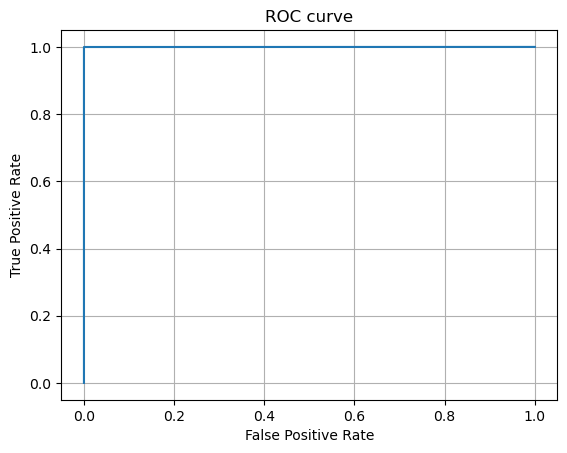

AUC-ROC:  0.9998880429914913


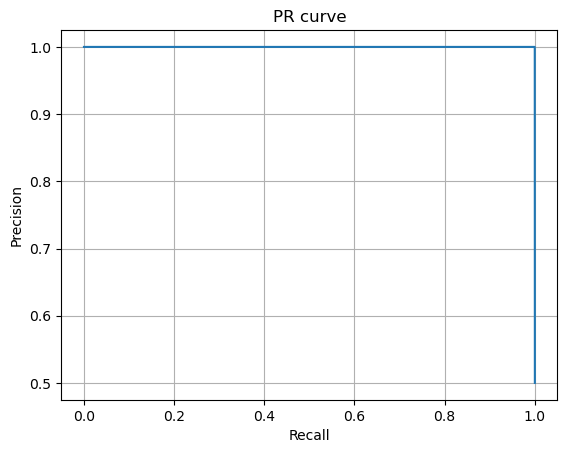

AUC-PR:  0.9999440214957456


In [8]:
# test
batch_count = 0

model.eval()
with torch.no_grad():
    ts = torch.Tensor().cuda()
    ps = torch.Tensor().cuda()

    for x, t in test_dataloader:
        y = model(x)
        p = torch.sigmoid(y)

        t_tmp = t
        p_tmp = p

        if test_dataloader.iteration == 0:
            ts = t_tmp
            ps = p_tmp
        else:
            ts = torch.cat((ts, t_tmp), dim=0)
            ps = torch.cat((ps, p_tmp), dim=0)

    label = ts[:, 0].cpu()
    probability = ps[:, 0].cpu()
    y_pred = ps.argmin(dim=1).cpu()
    
    # confusion matrix
    conf_matrix = metrics.confusion_matrix(label, y_pred)
    print(conf_matrix)
    """
                        Predicted
                    Negative  Positive
    Actual Negative     TN        FP
           Positive     FN        TP
    
    """
    print("正解率: ", metrics.accuracy_score(label, y_pred))
    print("適合率: ", metrics.precision_score(label, y_pred))
    print("再現率: ", metrics.recall_score(label, y_pred))
    print("F1値: ", metrics.f1_score(label, y_pred))

    # ROC-AUC
    fpr, tpr, thresholds = metrics.roc_curve(label, y_pred)
    plt.plot(fpr, tpr, label="ROC curve")
    plt.title("ROC curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()
    print("AUC-ROC: ", metrics.roc_auc_score(label, y_pred))

    # PR-AUC
    precision, recall, thresholds = metrics.precision_recall_curve(label, y_pred)
    auc = metrics.auc(recall, precision)
    plt.plot(recall, precision, label="PR curve")
    plt.title("PR curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.show()
    print("AUC-PR: ", auc)

In [11]:
# output convolution weights
state_dict = model.conv.state_dict()
kernel = state_dict['weight']

print(kernel.shape)
kernel??

torch.Size([128, 5, 9])
